In [211]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 


In [212]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
from google.colab import files
uploaded = files.upload()

Saving audi.csv to audi.csv


In [213]:
audi_df = pd.read_csv('audi.csv')
audi_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [214]:
audi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [215]:
today = date.today()
current_year = today.year

audi_df['years_old'] = current_year - audi_df['year']
audi_df.drop(['year'], axis=1, inplace=True)
audi_df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,years_old
0,A1,12500,Manual,15735,Petrol,150,55.4,1.4,5
1,A6,16500,Automatic,36203,Diesel,20,64.2,2.0,6
2,A1,11000,Manual,29946,Petrol,30,55.4,1.4,6
3,A4,16800,Automatic,25952,Diesel,145,67.3,2.0,5
4,A3,17300,Manual,1998,Petrol,145,49.6,1.0,3


In [216]:
target_feature = ['price']
numeric_features = [audi_df.select_dtypes(['int64','float64']).columns]
categorical_features = [audi_df.select_dtypes(['object']).columns]

#del numeric_features[0]
list(numeric_features), list(categorical_features)

([Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'years_old'], dtype='object')],
 [Index(['model', 'transmission', 'fuelType'], dtype='object')])

In [217]:
numeric_features.pop(0)

Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'years_old'], dtype='object')

In [218]:
ct = make_column_transformer(
    (MinMaxScaler(), ['mileage', 'tax', 'mpg', 'engineSize', 'years_old']),
    (OneHotEncoder(handle_unknown="ignore"), ['model', 'transmission', 'fuelType'])
)


X = audi_df.drop(['price'], axis=1)
y = audi_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
ct.fit(X_train)

X_train_normal = ct.transform(X_train)
X_train_normal = X_train_normal.toarray()

X_test_normal = ct.transform(X_test)
X_test_normal = X_test_normal.toarray()

In [219]:
X_train.shape, X_train_normal.shape

((8534, 8), (8534, 36))

In [220]:
type(X_train), type(X_train_normal)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [221]:
model_audi = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=[36]),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])

model_audi.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 5)

model_audi.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 100)               3700      
                                                                 
 dense_43 (Dense)            (None, 100)               10100     
                                                                 
 dense_44 (Dense)            (None, 1)                 101       
                                                                 
Total params: 13,901
Trainable params: 13,901
Non-trainable params: 0
_________________________________________________________________


In [222]:
model_history = model_audi.fit(X_train_normal, y_train, epochs=100, callbacks=[callback])

Epoch 1/100
267/267 [==============================] - 1s 2ms/step - loss: 21365.2051 - root_mean_squared_error: 24374.5391
Epoch 2/100
267/267 [==============================] - 1s 2ms/step - loss: 9793.0830 - root_mean_squared_error: 14150.4688
Epoch 3/100
267/267 [==============================] - 1s 2ms/step - loss: 6863.1025 - root_mean_squared_error: 10634.7393
Epoch 4/100
267/267 [==============================] - 1s 3ms/step - loss: 6033.7285 - root_mean_squared_error: 9623.6104
Epoch 5/100
267/267 [==============================] - 1s 2ms/step - loss: 5608.8374 - root_mean_squared_error: 8999.7441
Epoch 6/100
267/267 [==============================] - 1s 2ms/step - loss: 5294.9775 - root_mean_squared_error: 8582.6719
Epoch 7/100
267/267 [==============================] - 1s 3ms/step - loss: 4978.8721 - root_mean_squared_error: 8184.1372
Epoch 8/100
267/267 [==============================] - 1s 2ms/step - loss: 4660.6792 - root_mean_squared_error: 7774.4609
Epoch 9/100
267/267 

Text(0.5, 0, 'Epochs')

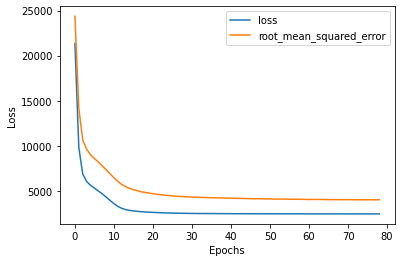

In [223]:
pd.DataFrame(model_history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [224]:
y_preds = model_audi.predict(X_test_normal)
y_preds = y_preds.squeeze()
y_preds = pd.Series(y_preds)

In [225]:
model_audi_loss, model_audi_mae = model_audi.evaluate(X_test_normal, y_test)
model_audi_loss, model_audi_mae

67/67 [==============================] - 0s 2ms/step - loss: 2593.7451 - root_mean_squared_error: 4195.4023


(2593.7451171875, 4195.40234375)

In [226]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

In [231]:
type(y_preds), type(y_test), y_preds.shape, y_test.shape, X_test.shape

(numpy.ndarray, numpy.ndarray, (2134, 1), (2134, 1), (2134, 8))

In [230]:
y_preds = y_preds.values.reshape(-1,-1)
y_test = y_test.values.reshape(-1,-1)

y_preds = pd.Series(y_preds)
y_test = pd.Series(y_test)

AttributeError: ignored

In [232]:
type(y_preds), type(y_test), y_preds.shape, y_test.shape

(numpy.ndarray, numpy.ndarray, (2134, 1), (2134, 1))

TypeError: ignored

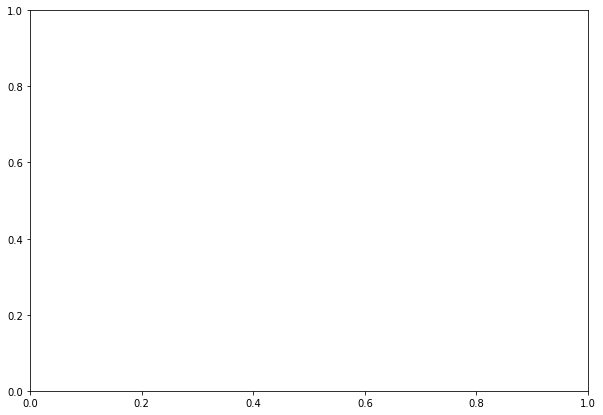

In [233]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)